In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.util as model_util
import model.cnn as cnn
import feature.experimental_dataset as experimental_dataset
import feature.util as feature_util
import train.train_model as train_model
import train.performance as performance
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logomaker
import scipy.signal
import scipy.special

In [2]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [3]:
base_path = "/projects/site/gred/resbioai/tsenga5/mechint_regnet/"

In [4]:
# model_path = os.path.join(base_path, "models/trained_models/experimental/chipseq_ctcf_hepg2/standard_cnn/1/last_ckpt.pth")
# peaks_bed_path = os.path.join(base_path, "data/encode/chipseq/ENCSR607XFI_CTCF_HepG2/ENCFF664UGR_idrpeaks.bed.gz")

In [5]:
# model_path = os.path.join(base_path, "models/trained_models/experimental/chipseq_max_hepg2/standard_cnn/2/last_ckpt.pth")
# peaks_bed_path = os.path.join(base_path, "data/encode/chipseq/ENCSR168DYA_MAX_HepG2/ENCFF254ZDA_idrpeaks.bed.gz")

In [6]:
model_path = os.path.join(base_path, "models/trained_models/experimental/chipseq_foxa1_hepg2/standard_cnn/3/last_ckpt.pth")
peaks_bed_path = os.path.join(base_path, "data/encode/chipseq/ENCSR865RXA_FOXA1_HepG2/ENCFF081USG_idrpeaks.bed.gz")

In [7]:
# model_path = os.path.join(base_path, "models/trained_models/experimental/dnase_hl60/standard_cnn/1/last_ckpt.pth")
# peaks_bed_path = os.path.join(base_path, "data/encode/dnase/ENCSR889WKL_HL60/ENCFF773SFA_peaks.bed.gz")

### Show training curves

In [8]:
metrics_path = os.path.join(os.path.dirname(model_path), "metrics.json")
with open(metrics_path, "r") as f:
    metrics = json.load(f)

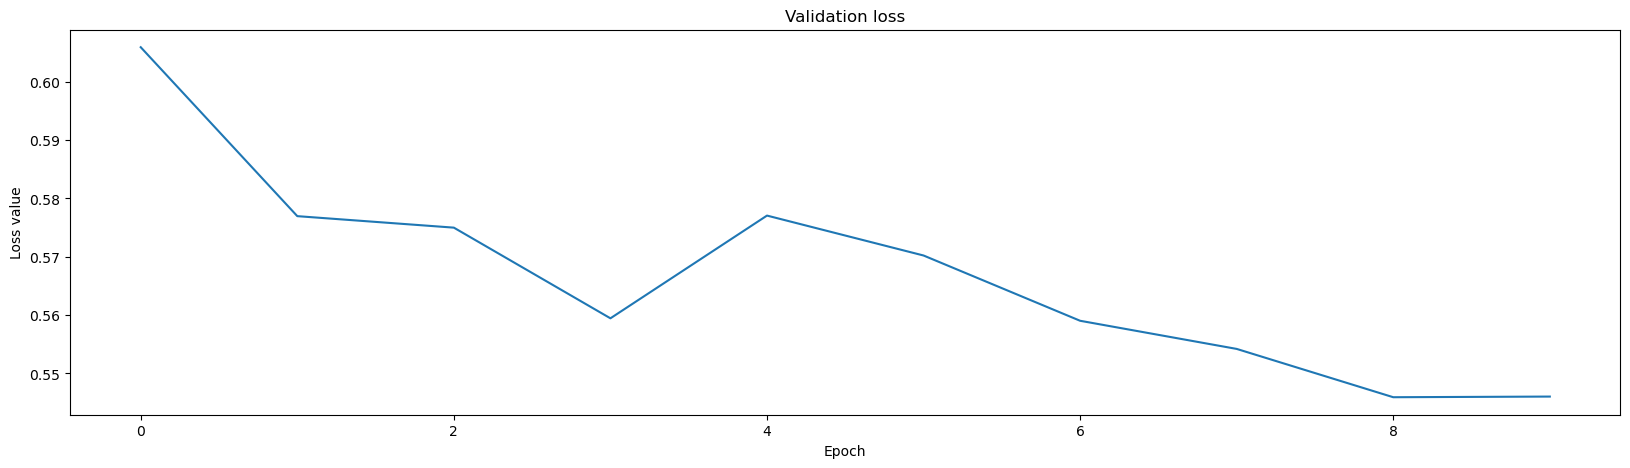

In [9]:
val_losses = metrics["val_epoch_loss"]["values"]

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(np.arange(len(val_losses)), val_losses)
ax.set_title("Validation loss")
ax.set_ylabel("Loss value")
ax.set_xlabel("Epoch")
plt.show()

### Import model and create data loader

In [10]:
model = model_util.load_model(
    cnn.ConvNet, model_path
).to(DEVICE)

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
data_loader = experimental_dataset.dataset_ex.run(
    "create_data_loader", config_updates={
        "peaks_bed_path": peaks_bed_path,
        "batch_size": 128,
        "chrom_set": ["chr1"]
    }
).result

data_loader.dataset.on_epoch_start()

### Run predictions

In [ ]:
losses_batched, losses, model_outputs, _, _, input_data = \
    train_model.run_epoch(data_loader, "eval", model, epoch_num=0, return_extras=True)

In [ ]:
for i in range(len(input_data)):
    input_data[i] = input_data[i][:128]
model_outputs = model_outputs[:128]

In [ ]:
true_labels, pred_probs = np.squeeze(input_data[1], axis=1), np.squeeze(model_outputs, axis=1)

In [ ]:
# Extract convolutional filter weights
conv_weights = model.conv_layers[0][0].weight.detach().cpu().numpy()  # Shape: F x 4 x W

### Compute performance metrics

In [ ]:
metrics = performance.compute_performance_metrics(true_labels, pred_probs)
max_key_len = max(len(k) for k in metrics.keys())
for key, val in metrics.items():
    print("%s: %6.4f" % (key.ljust(max_key_len), val))

### Visualize convolutional filter weights

In [ ]:
def create_dna_logo(matrix, ax=None):
    """
    Creates a DNA logo using the logomaker package.
    Arguments:
        `matrix`: an L x 4 array of values to plot, in ACGT order
        `ax`: Axes object on which to plot
    Returns the resulting Logo object.
    """
    data = pd.DataFrame(matrix, columns=["A", "C", "G", "T"])
    logo = logomaker.Logo(data, ax=ax)
    return logo

In [ ]:
num_cols = 2
num_rows = int(np.ceil(len(conv_weights) / 2))
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 4))
if len(ax.shape) == 1:
    ax = ax[None]

# Mean-center
conv_weights_centered = conv_weights - np.mean(conv_weights, axis=1, keepdims=True)

min_height = np.min(np.sum(np.minimum(conv_weights_centered, 0), axis=1))
max_height = np.max(np.sum(np.maximum(conv_weights_centered, 0), axis=1))
ylims = (min_height, max_height)
for filter_i in range(len(conv_weights)):
    i, j = filter_i % num_rows, filter_i // num_rows
    
    weights = np.transpose(conv_weights_centered[filter_i])
    
    create_dna_logo(weights, ax=ax[i, j])
    ax[i, j].set_ylim(ylims)
    ax[i, j].set_title("Filter %d" % filter_i)
plt.show()

### Quantify interpretability

**Compare filter weights to true motif PFMs**

In [ ]:
def compute_pfm_similarity(pfm_1, pfm_2):
    """
    Given an L1 x 4 NumPy array and L2 x 4 NumPy array, computes the
    similarity between them as the maximum sliding cross correlation.
    """
    # L1-normalize both
    pfm_1 = pfm_1 / np.sum(np.abs(pfm_1), axis=1, keepdims=True)
    pfm_2 = pfm_2 / np.sum(np.abs(pfm_2), axis=1, keepdims=True)

    return np.max(scipy.signal.correlate(pfm_1, pfm_2, mode="valid"))

In [ ]:
# Import known motifs
known_motifs_path = "/home/tsenga5/mechint_regnet/data/databases/JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme.txt"
true_pfms = feature_util.import_meme_motifs(known_motifs_path)

In [ ]:
# For each filter, compute the closest true PFM
for filter_i in range(len(conv_weights)):
    filter_weights = np.transpose(conv_weights[filter_i])
    filter_weights = scipy.special.softmax(filter_weights, axis=1)
    filter_weights_rc = np.flip(filter_weights)

    pfm_sims = {
        pfm_key : compute_pfm_similarity(filter_weights, pfm)
        for pfm_key, pfm in true_pfms.items()
    }
    pfm_sims_rc = {
        pfm_key : compute_pfm_similarity(filter_weights_rc, pfm)
        for pfm_key, pfm in true_pfms.items()
    }
    all_pfm_sims = pfm_sims.copy()
    all_pfm_sims.update({key + "_RC" : sim for key, sim in pfm_sims_rc.items()})
    print("%d\t%s" % (
        filter_i,
        "\t".join(["%s:%.3f" % (key, all_pfm_sims[key]) for key in sorted(all_pfm_sims, key=(lambda k: -all_pfm_sims[k]))[:10]])
    ))